In [5]:
import jax
import jax.numpy as jnp
import numpy as np

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from ott.geometry.costs import ElasticSTVS, ElasticL1, ElasticL2, ElasticSqKOverlap

In [6]:
def transform(x, s):
    return jnp.concat([jnp.exp(x[:,:s]), x[:,s:]], axis=1)

In [7]:
rngs = jax.random.split(jax.random.PRNGKey(0), 4)
s = 5
d = 100
n = 1000
x = jax.random.uniform(rngs[0], (n,d))
y = jax.random.uniform(rngs[1], (n,d))
y = transform(y, s)

In [8]:
n_points = 10

solver = sinkhorn.Sinkhorn()
costs = {
    "l1": ElasticL1,
    "tau_stvs": ElasticSTVS,
    "l2": ElasticL2,
    "ovk_5": lambda x: ElasticSqKOverlap(5, scaling_reg=x),
    "ovk_7": lambda x: ElasticSqKOverlap(7, scaling_reg=x)
    }
res = {
    "l1": [],
    "tau_stvs": [],
    "l2": [],
    "ovk_5": [],
    "ovk_7": []
}

for cost_name, cost_fn in costs.items():
    for reg in np.logspace(-2, 2, n_points):
        cost = pointcloud.PointCloud(x, y, cost_fn=cost_fn(reg))
        prob = linear_problem.LinearProblem(cost)
        out = solver(prob)
        dual_potentials = out.to_dual_potentials()
        res[cost_name].append(mean_squared_error(transform(x, s), dual_potentials.transport(x))/d)

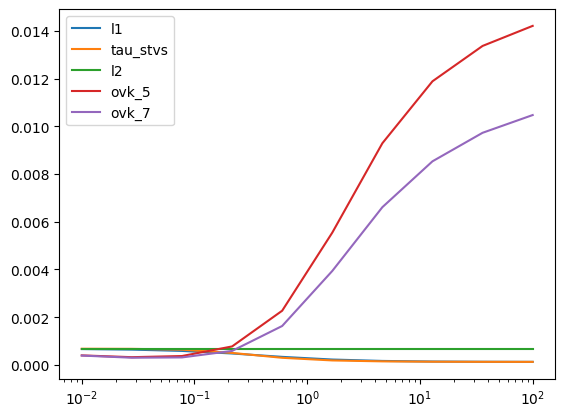

In [10]:
for cost_name, cost_res in res.items():
    plt.semilogx(np.logspace(-2, 2, n_points), cost_res, label=cost_name)
plt.legend()